# 0. IMPORTS

## 0.1. Importing libraries

In [1]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import warnings
import inflection
import xgboost as xgb
import seaborn as sns
import datetime

from scipy                 import stats as ss
from boruta                import BorutaPy
from IPython.display       import Image
from IPython.core.display  import HTML
from matplotlib            import pyplot as plt

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

## 0.2. Loading data

In [2]:
# Importar os datasets
df_sales_raw = pd.read_csv('../datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../datasets/store.csv', low_memory=False)

# Unir os datasetes
df_raw = df_store_raw.merge(df_sales_raw, how='inner', on='Store')

## 0.3. Helper functions

In [55]:
# Função para deixar gráficos pré-configurado
def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

# Função para renomear as colunas do dataframe
def rename_columns(cols):
    title = lambda x: inflection.titleize(x)
    snakecase = lambda x: inflection.underscore(x)
    spaces = lambda x: x.replace( " ", "" )
    cols = list(map( title, cols ))
    cols = list(map( spaces, cols )) 
    cols = list(map( snakecase, cols ))
    return cols   

# Função que encoda variáveis categóricas
def dummies(df_aux, variable):
  df_aux = pd.get_dummies(df_aux, prefix=variable, columns=[variable])
  return df_aux

# Função para fazer o heatmap de variáveis categóricas
def cramer_v( x, y ):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [4]:
jupyter_settings();

# 1. PASSO 01 - DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
df1.columns = rename_columns( df1.columns )

## 1.2. Data Dimensions

In [7]:
print('Number of rows: {:,}'.format( df1.shape[0] ))
print('Number of columns: {:,}'.format( df1.shape[1] ))

Number of rows: 1,017,209
Number of columns: 18


## 1.3. Data Types

In [8]:
df1.dtypes

store                             int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
dtype: object

## 1.4. Check  NA's

In [9]:
df1.isna().sum()

store                                0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
dtype: int64

## 1.5. Fillout NA's

In [10]:
# Alterar o tipo 'date' para datetime para usar na função lambda abaixo
df1['date'] = pd.to_datetime( df1['date'] )

# 'competition_distance': distância em metros até a loja concorrente mais próxima
# --> Número de NA's: 2,642.
# --> Preencher com uma distância grande para indicar que não há concorrência próxima.
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 100000.0 
                                                                 if math.isnan(x) else x )

# 'competition_open_since_month': o mês aproximado da hora em que o concorrente mais próximo foi aberto
# --> Número de NA's: 323,348.
# --> Preencher com o mês da coluna 'date'.
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month 
                                                 if math.isnan(x['competition_open_since_month']) 
                                                 else x['competition_open_since_month'], axis=1 )

# 'competition_open_since_year': o ano aproximado da hora em que o concorrente mais próximo foi aberto
# --> Número de NA's: 323,348.
# --> Preencher com o ano da coluna 'date'.
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year 
                                                if math.isnan(x['competition_open_since_year']) 
                                                else x['competition_open_since_year'], axis=1 )

# 'promo2_since_week': descreve a semana do calendário em que a loja começou a participar do Promo2
# --> Número de NA's: 508,031.
# --> Preencher com a semana da coluna 'date'.
df1['promo2_since_week'] = df1.apply ( lambda x: x['date'].week
                                       if math.isnan(x['promo2_since_week'])
                                       else x['promo2_since_week'], axis=1 ) 

# 'promo2_since_year': descreve o ano em que a loja começou a participar do Promo2
# --> Número de NA's: 508,031.
# --> Preencher com o ano da coluna 'date'
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year
                                      if math.isnan(x['promo2_since_year'])
                                      else x['promo2_since_year'], axis=1)

# 'promo_interval': descreve os intervalos consecutivos em que o Promo2 é iniciado, nomeando os meses em que a promoção é iniciada novamente.
# --> Número de NA's: 508,031.
# --> Preencher com 0's.
df1['promo_interval'].fillna( 0, inplace=True )

## 1.6. Change Data Types

In [11]:
# Alterar os tipos de float para int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

df1.dtypes

store                                    int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
dtype: object

## 1.7. Descriptive Statics

In [12]:
num_attributes = df1.select_dtypes( include = ['int64', 'int32', 'float64'] )
cat_attributes = df1.select_dtypes( exclude = ['int64', 'int32', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical attributes

In [13]:
# Tendência central (mean and median) 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Medidas de dispersão (min, max, range, std, skew and kurtosis)
d1 = pd.DataFrame( num_attributes.apply( min ) ).T 
d2 = pd.DataFrame( num_attributes.apply( max ) ).T 
d3 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d4 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# Concatenar
m = pd.concat( [d1, d2, d3, ct1, ct2, d4, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,competition_distance,20.0,100000.0,99980.0,5675.712376,2330.0,9085.159292,4.637208,35.287543
2,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
3,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304
4,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
5,promo2_since_week,1.0,52.0,51.0,23.619033,22.0,14.310057,0.178723,-1.184046
6,promo2_since_year,2009.0,2015.0,6.0,2012.793297,2013.0,1.662657,-0.784436,-0.210075
7,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
8,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
9,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773


### 1.7.2. Categorical  attributes

In [14]:
# Número de conteúdos únicos das variáveis categóricas
cat_attributes.apply( lambda x: x.nunique() )

store_type        4
assortment        3
promo_interval    4
state_holiday     4
dtype: int64

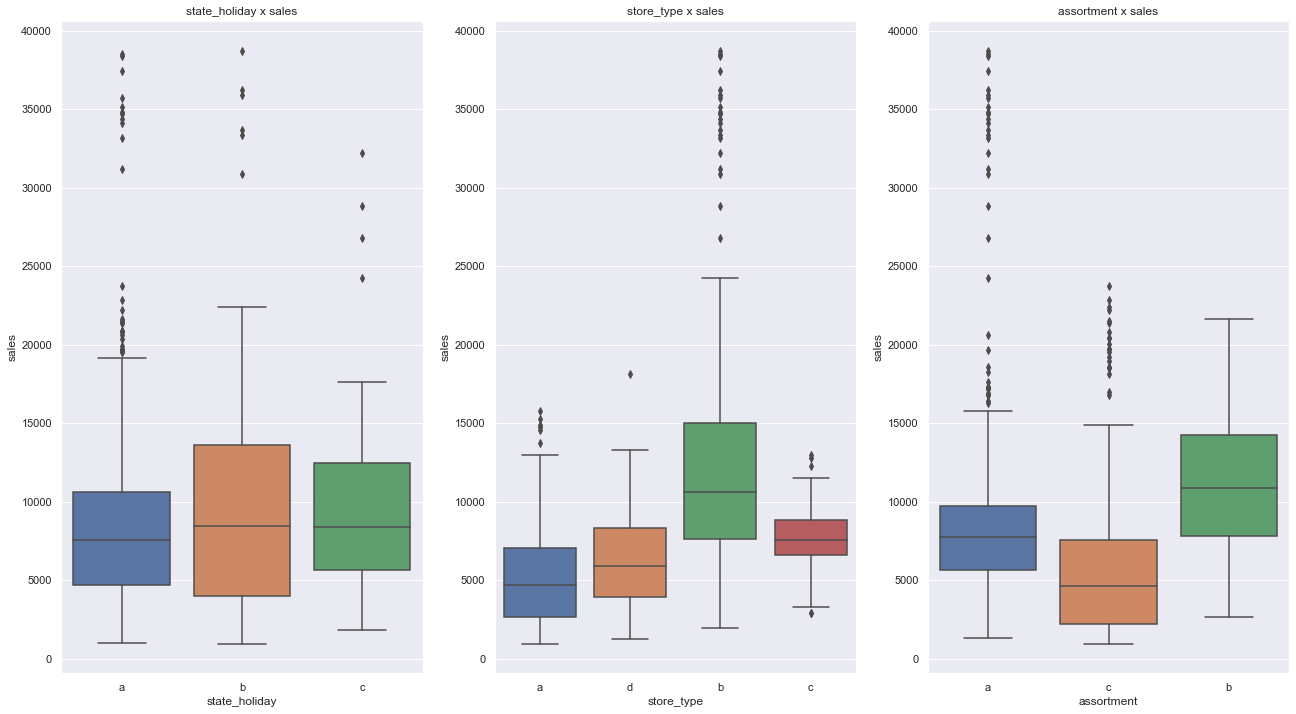

In [15]:
# Filtrar dados que não era feriado estadual e houve vendas
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

# Criar uma figura com 3 subplots e define o tamanho
fig, axs = plt.subplots( 1, 3, figsize=(22, 12) )

# Plotar 'state_holiday' x 'sales' filtrado
sns.boxplot( x='state_holiday', y='sales', data=aux, ax=axs[0] )
axs[0].set_title( 'state_holiday x sales' )

# Plotar 'store_type' x 'sales' filtrado
sns.boxplot( x='store_type', y='sales', data=aux, ax=axs[1] )
axs[1].set_title( 'store_type x sales' )

# Plotar 'assortment' x 'sales' filtrado
sns.boxplot( x='assortment', y='sales', data=aux, ax=axs[2] )
axs[2].set_title( 'assortment x sales' )

# Mostra o gráfico
plt.show()

# 2. PASSO 02 - FEATURE ENGINEERING

In [16]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

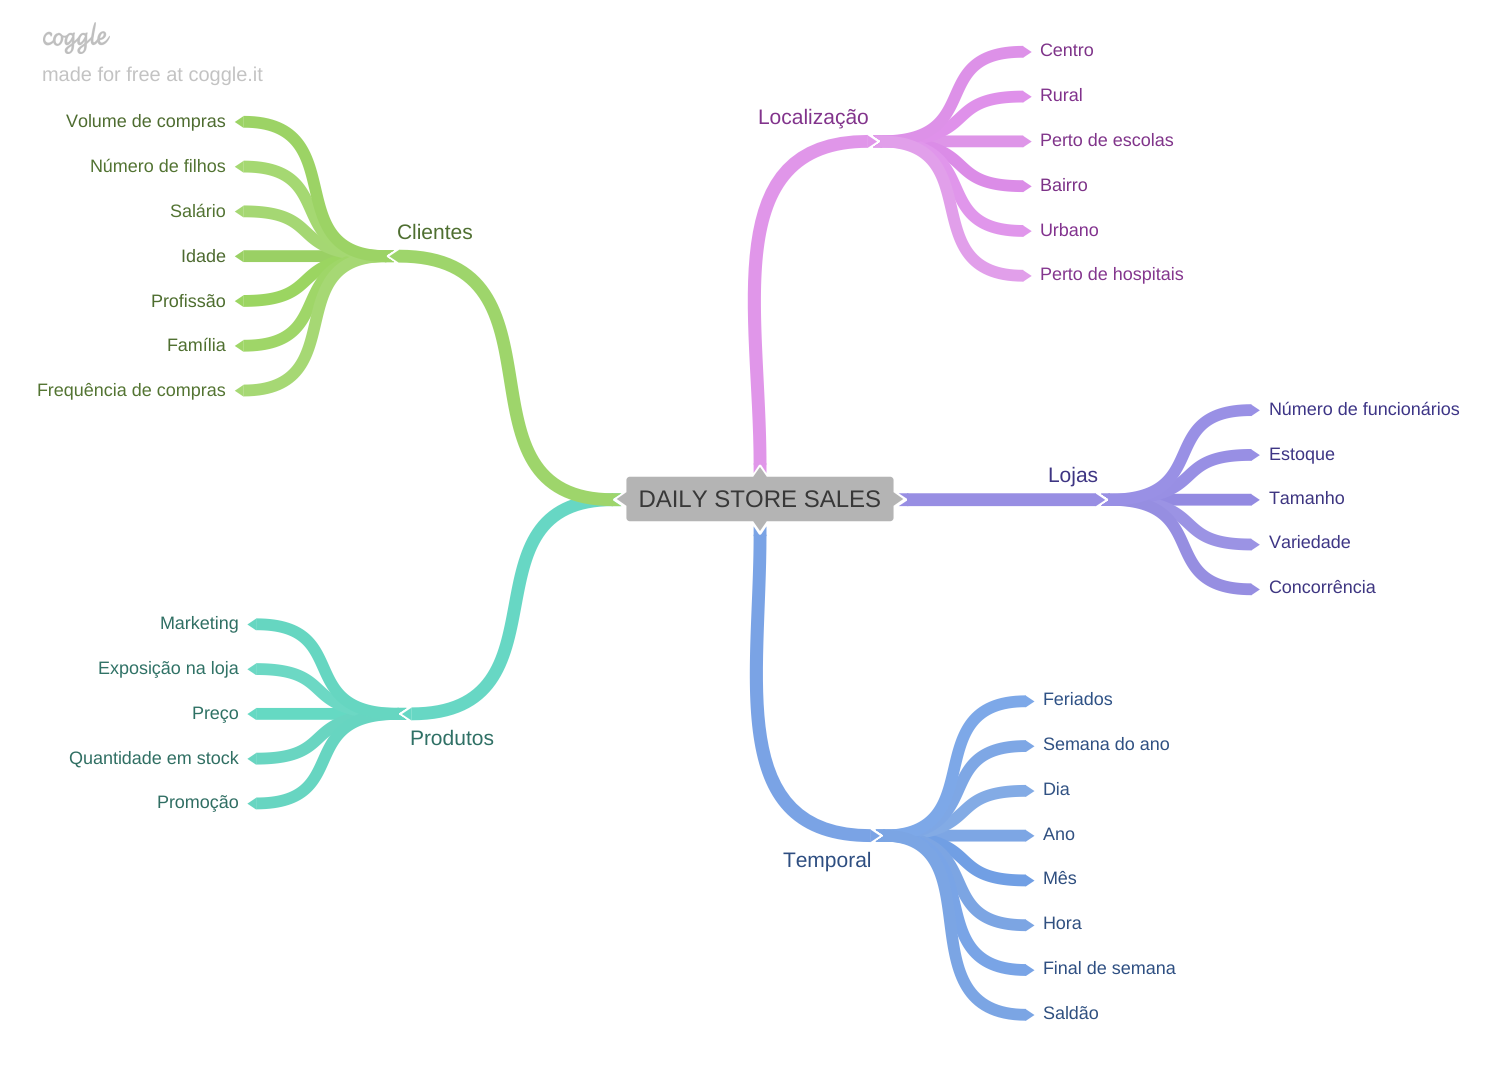

In [17]:
Image('../img/mind_map.png')

## 2.2. Criação das Hipóteses

### 2.2.1. Hipóteses Lojas

**HL1.** O dia da semana que mais vende é sábado

**HL2.** As lojas de tipo 'a' têm mais vendas

**HL3.** Quanto mais variedades, mais vendas

### 2.2.2. Hipóteses Feriados

**HF1.** Há mais vendas nos feriados estaduais

**HF2.** Há mais vendas nos feriados escolares

### 2.2.3. Hipóteses Promoções

**HP1.** Quanto mais promoções eventuais, mais vendas

**HP2.** Quanto mais promoções contínuas, mais vendas

**HP3.** Quanto mais tempo de promoção, mais vendas

**HP4.** Quanto menor o intervalo entre as promoções, mais vendas

### 2.2.4. Hipóteses Concorrência

**HC1.** Quanto maior a distância da concorrência, mais vendas

**HC2.** Após abertura de concorrência, as vendas diminuem

## 2.3. Lista Final de Hipóteses

**HL1.** O dia da semana que mais vende é sábado

**HL2.** As lojas de tipo 'a' têm mais vendas

**HL3.** Quanto mais variedades, mais vendas

**HF1.** Há mais vendas nos feriados estaduais

**HF2.** Há mais vendas nos feriados escolares

**HP1.** Quanto mais promoções eventuais, mais vendas

**HP2.** Quanto mais promoções contínuas, mais vendas

**HP3.** Quanto mais tempo de promoção, mais vendas

**HP4.** Quanto menor o intervalo entre as promoções, mais vendas

**HC1.** Quanto maior a distância da concorrência, mais vendas

**HC2.** Após abertura de concorrência, as vendas diminuem

## 2.4. Feature Engineering

In [18]:
# Converter os códigos de 'state_holiday' em nome (a: public_holiday, b: easter_holiday, c: christmas, 0: regular_day)
state_holiday_rename = {'a': 'public_holiday', 'b': 'easter_holiday', 'c': 'christmas', '0': 'regular_day'}
df2['state_holiday'] = df2['state_holiday'].map(state_holiday_rename)

# Converter os códigos de 'assortment' em nível de variedades de produtos (a: basic, b: extra, c: extended)
assortment_rename = {'a': 'basic', 'b': 'extra', 'c': 'extended'}
df2['assortment'] = df2['assortment'].map(assortment_rename)

# Incluir a feature 'year_week' derivado da data de venda
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# Incluir a feature 'year' derivado da data de venda
df2['year'] = df2['date'].dt.year

# Incluir a feature 'month' derivado da data de venda
df2['month'] = df2['date'].dt.month

# competition since
#df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
#df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# 3. PASSO 03 - FILTRAGEM DE VARIÁVEIS

## 3.1. Filtragem das Linhas

In [19]:
# Filtrar apenas lojas abertas e com vendas
df3 = df2.loc[( df2['open'] != 0 ) & ( df2['sales'] > 0 ), :].reset_index(drop=True)

In [20]:
print('Number of rows: {:,}'.format(df3.shape[0]))
print('Number of columns: {:,}'.format(df3.shape[1]))

Number of rows: 844,338
Number of columns: 21


## 3.2. Seleção das Colunas

In [21]:
# Remover colunas que não serão utilizadas
# --> 'customers': Remover, pois precisaríamos ter a previsão da quantidade de clientes em cada loja nas próximas seis semanas.
# --> 'open': Remover, pois já selecionamos somente lojas abertas.

cols_drop = ['customers', 'open']
df3 = df3.drop( cols_drop, axis=1 )

In [22]:
num_attributes = df3.select_dtypes( include = ['int64', 'int32', 'float64'] )
cat_attributes = df3.select_dtypes( exclude = ['int64', 'int32', 'float64', 'datetime64[ns]'] )

# 4. PASSO 04 - EXPLORATORY DATA ANALYSIS (EDA)

- Como as variáveis impactam o fenômeno?
- Qual é a força deste impacto? 
- Validação de hipóteses de negócio e geração de insights;
- Perceber variáveis que são importantes para o modelo.

In [23]:
df4 = df3.copy()

## 4.1. Análise Univariada
- Como são as variáveis? (min, max, distribuição, range etc)

Feature | Description | Content
-- | -- | --
store | a unique Id for each store | unique for each one
store_type | differentiates between 4 different store models | a, b, c, d
assortment | describes an assortment level | a: basic, b: extra, c: extended
competition_distance | distance in meters to the nearest competitor store | min: 20.0 m, max: 75,860.0 
competition_open_since_month | gives the approximate month of the time the nearest competitor was opened | from 1 to 12
competition_open_since_year | gives the approximate year of the time the nearest competitor was opened | min: 1900, max: 2015
promo2 | a continuing and consecutive promotion for some stores | 0: store is not participating, 1: store is participating
promo2_since_week | describes the calendar week when the store started participating in Promo2 | from 1 to 50
promo2_since_year | describes the year when the store started participating in Promo2 | min: 2009, _max: 2015
promo_interval | describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. | Month's names: ['Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec']
day_of_week | day of week | from 1 to 7
date | date of sale | min: 2013-01-01, max: 2015-07-31
sales | the turnover for any given day | (this is what you are predicting)
customers | the number of customers on a given day | min: 0, max: 7,388
open | an indicator for whether the store was open | 0: closed, 1: open
promo | indicates whether a store is running a promo on that day | 0: no, 1: yes
state_holiday | indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends |  a: public holiday, b: Easter holiday, c: Christmas, 0: None
school_holiday | indicates if the (Store, Date) was affected by the closure of public schools | 0: closed, 1: open

### 4.1.1. Response Variable

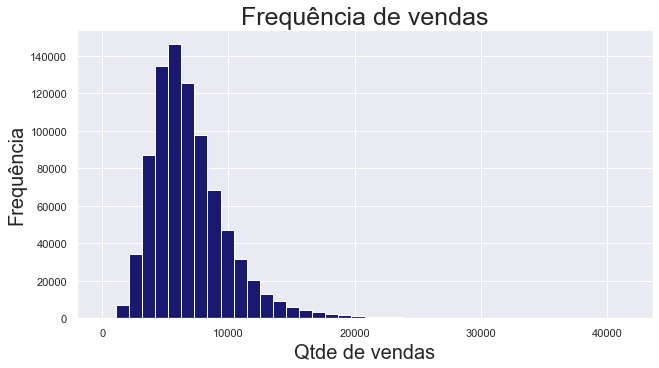

In [24]:
# Cria o gráfico
fig = plt.figure( figsize = (8, 4))
ax = fig.add_axes([0, 0, 1, 1])

# Configura o título e os eixos
ax.set_title('Frequência de vendas', fontsize=25)
ax.set_xlabel('Qtde de vendas', fontsize=20)
ax.set_ylabel('Frequência', fontsize=20)

# Plota e mostra o gráfico
ax.hist( df4['sales'], bins=40, color='midnightblue')
plt.show()

### 4.1.2. Numerical Variable

**CONCLUSÕES**

- competition_distance: A maioria da concorrência está perto, a aproximadamente 5km de distância.
- promo: As promoções pontuais são relativamente muitas.
- promo2: As promoções contínuas são tão frequentes quanto os dias normais.
- day_of_week: O domingo é muito menos frequente do que os demais dias.
- customers: A quantidade mais comum de clientes por dia nas lojas é entre 300 a 1,000.
- school_holiday: Os feriados escolares têm uma frequência relevante.
- state_holiday: Todos os feriados juntos representam 1% do total, o que as torna irrelevantes.
- assortment: O tipo de variedade 'extra' é muito menos frequente do que a básica e a estendida, talvez seja o caso de juntá-la a estendida para formarmos uma de 'sim' ou 'não'.

In [25]:
num_attributes.columns

Index(['store', 'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'day_of_week', 'sales', 'promo', 'school_holiday',
       'year', 'month'],
      dtype='object')

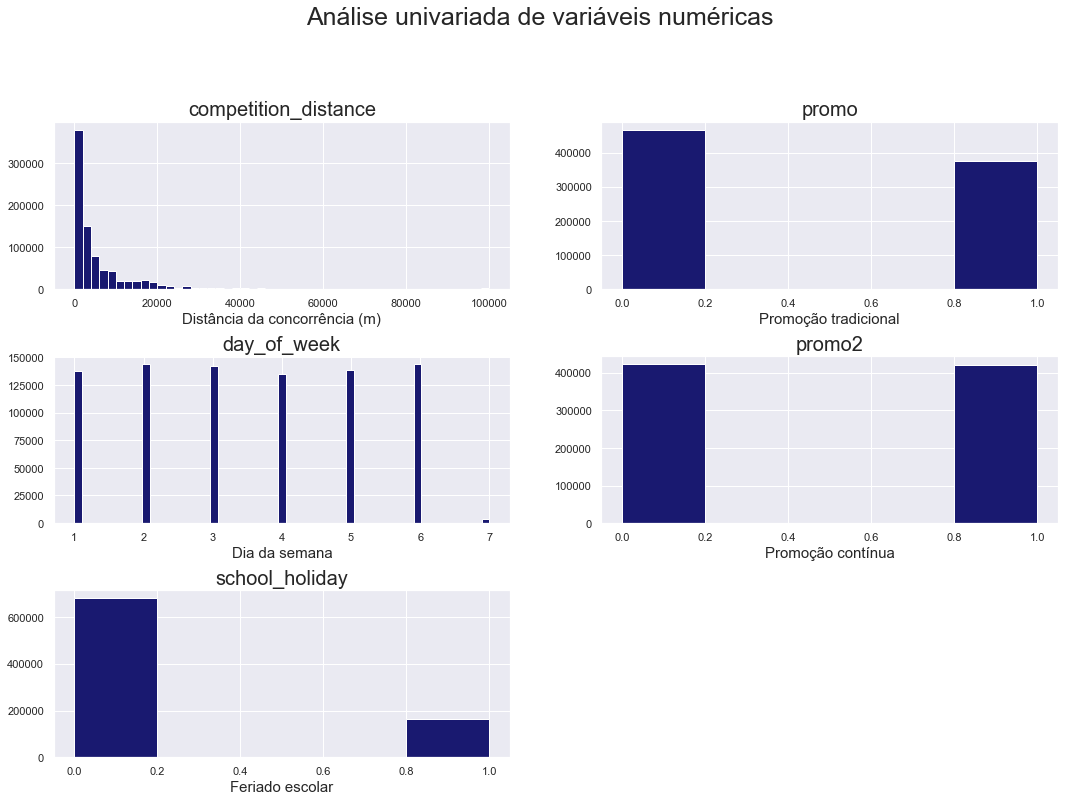

In [26]:
# Cria o gráfico
fig = plt.figure( figsize = (18, 16))

# Configura o título
fig.suptitle('Análise univariada de variáveis numéricas', fontsize=25)
cor = 'midnightblue'

# Adiciona o primeiro subplot
ax1 = fig.add_subplot(4, 2, 1)
ax1.hist(df4['competition_distance'], bins=50, color=cor)
ax1.set_title('competition_distance', fontsize=20)
ax1.set_xlabel('Distância da concorrência (m)', fontsize=15)

# Adiciona o segundo subplot
ax2 = fig.add_subplot(4, 2, 2)
ax2.hist(df4['promo'], bins=5, color=cor)
ax2.set_title('promo', fontsize=20)
ax2.set_xlabel('Promoção tradicional', fontsize=15)

# Adiciona o terceiro subplot
ax3 = fig.add_subplot(4, 2, 3)
ax3.hist(df4['day_of_week'], bins=55, color=cor)
ax3.set_title('day_of_week', fontsize=20)
ax3.set_xlabel('Dia da semana', fontsize=15)

# Adiciona o quarto subplot
ax4 = fig.add_subplot(4, 2, 4)
ax4.hist(df4['promo2'], bins=5, color=cor)
ax4.set_title('promo2', fontsize=20)
ax4.set_xlabel('Promoção contínua', fontsize=15)

# Adiciona o quinto subplot
ax5 = fig.add_subplot(4, 2, 5)
ax5.hist(df4['school_holiday'], bins=5, color=cor)
ax5.set_title('school_holiday', fontsize=20)
ax5.set_xlabel('Feriado escolar', fontsize=15)

# Adiciona espaço vertical entre os subplots
fig.subplots_adjust(hspace=0.4)

# Plota e mostra o gráfico
plt.show()

### 4.1.3. Categorical Variable

In [27]:
cat_attributes.columns

Index(['store_type', 'assortment', 'promo_interval', 'state_holiday',
       'year_week'],
      dtype='object')

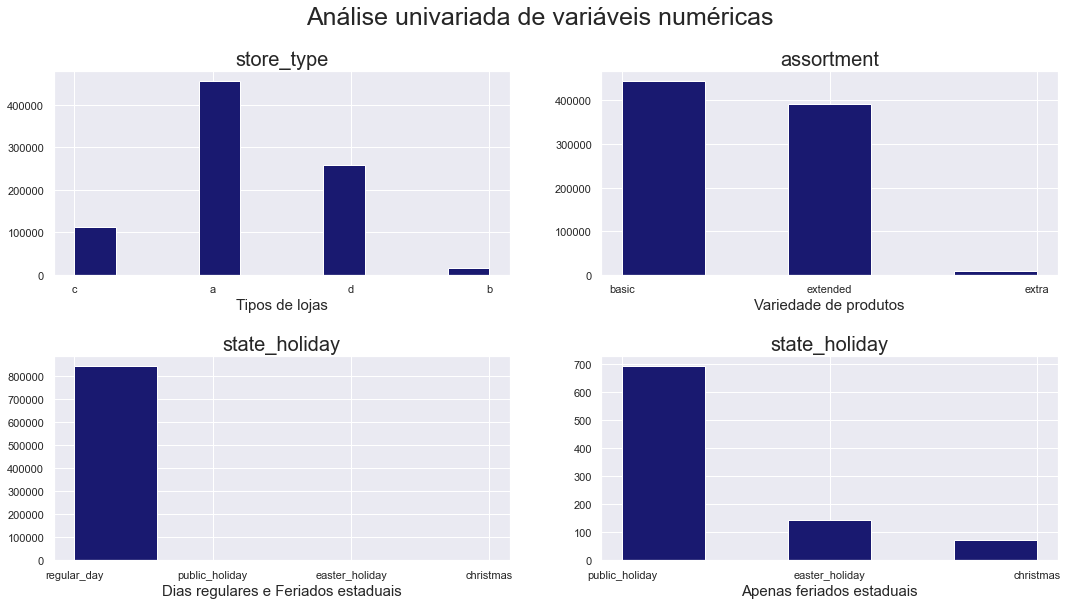

In [28]:
# Cria o gráfico
fig = plt.figure( figsize = (18, 9))

# Configura o título
fig.suptitle('Análise univariada de variáveis numéricas', fontsize=25)
cor = 'midnightblue'

# Adiciona o primeiro subplot
ax1 = fig.add_subplot(2, 2, 1)
ax1.hist(df4['store_type'], bins=10, color=cor)
ax1.set_title('store_type', fontsize=20)
ax1.set_xlabel('Tipos de lojas', fontsize=15)

# Adiciona o segundo subplot
ax2 = fig.add_subplot(2, 2, 2)
ax2.hist(df4['assortment'], bins=5, color=cor)
ax2.set_title('assortment', fontsize=20)
ax2.set_xlabel('Variedade de produtos', fontsize=15)

# Adiciona o terceiro subplot
ax3 = fig.add_subplot(2, 2, 3)
ax3.hist(df4['state_holiday'], bins=5, color=cor)
ax3.set_title('state_holiday', fontsize=20)
ax3.set_xlabel('Dias regulares e Feriados estaduais', fontsize=15)

# Adiciona o quarto subplot
aux = df4[df4['state_holiday'] != 'regular_day']
ax4 = fig.add_subplot(2, 2, 4)
ax4.hist(aux['state_holiday'], bins=5, color=cor)
ax4.set_title('state_holiday', fontsize=20)
ax4.set_xlabel('Apenas feriados estaduais', fontsize=15)

# Adiciona espaço vertical entre os subplots
fig.subplots_adjust(hspace=0.4)

# Plota e mostra o gráfico
plt.show()

## 4.2. Análise Bivariada
- Como a variável impacta no fenômeno? (Validação das hipóteses)
- Qual a força deste impacto?

### HL1. O dia da semana que mais vende é sábado
**FALSO:** SEGUNDA é o dia com MAIOR nº de vendas.

**SUGESTÃO DE MELHORIA:** No futuro, separar dias regulares e feriados para análise. 

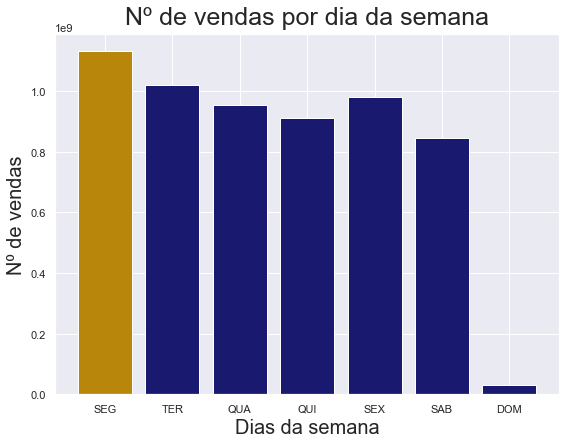

In [29]:
# Filtra e agrupa
vendas_por_dia_da_semana = df4.groupby('day_of_week')['sales'].sum().reset_index()

# Converte os códigos de 'day_of_week' em nomes de dias da semana
# --> Por se tratar de uma empresa europeia, o primeiro dia é a segunda-feira
day_of_week_rename = {1:'SEG', 2:'TER', 3:'QUA', 4:'QUI', 5:'SEX', 6:'SAB', 7:'DOM'}
vendas_por_dia_da_semana['day_of_week'] = vendas_por_dia_da_semana['day_of_week'].map(day_of_week_rename)

# Cria o gráfico
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])

# Define a lista de cores e destaca a maior
colors = ['midnightblue']*7
max_sales_idx = np.argmax(vendas_por_dia_da_semana['sales'])
colors[max_sales_idx] = 'darkgoldenrod'

# Configura o título e os eixos
ax.set_title('Nº de vendas por dia da semana', fontsize=25, pad=10)
ax.set_xlabel('Dias da semana', fontsize=20)
ax.set_ylabel('Nº de vendas', fontsize=20)

# Plota e mostra o gráfico
ax.bar(vendas_por_dia_da_semana['day_of_week'], vendas_por_dia_da_semana['sales'], color=colors)
plt.show()

### HL2. As lojas de tipo 'a' têm mais vendas
**VERDADE:** As lojas do tipo 'A' têm MAIOR quantidade de vendas

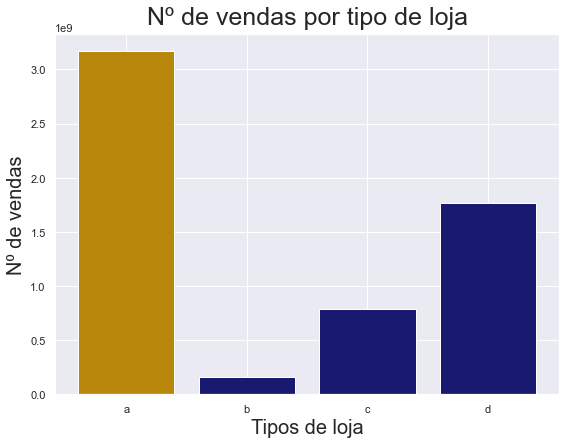

In [30]:
# Filtra e agrupa
df_aux = df4.groupby('store_type')['sales'].sum().reset_index()

# Cria o gráfico
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])

# Define a lista de cores e destaca a maior
colors = ['midnightblue']*4
max_sales_idx = np.argmax(df_aux['sales'])
colors[max_sales_idx] = 'darkgoldenrod'

# Configura o título e os eixos
ax.set_title('Nº de vendas por tipo de loja', fontsize=25, pad=10)
ax.set_xlabel('Tipos de loja', fontsize=20)
ax.set_ylabel('Nº de vendas', fontsize=20)

# Plota e mostra o gráfico
ax.bar(df_aux['store_type'], df_aux['sales'], color=colors)
plt.show()

### HL3. Quanto mais variedades, mais vendas
**FALSO:** As lojas com MAIOR variedade, vende MENOS.

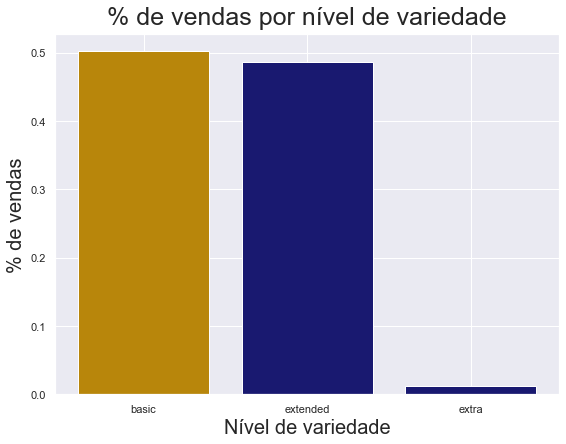

In [31]:
# Filtra e agrupa
df_aux = df4.loc[:, ['assortment', 'sales']].groupby('assortment').sum().reset_index()
df_aux['prop'] = df_aux['sales'] / df_aux['sales'].sum()

# Cria o gráfico
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])

# Define a lista de cores e destaca a maior
max_idx = df_aux['sales'].argmax()
colors = ['midnightblue'] * len(df_aux)
colors[max_idx] = 'darkgoldenrod'

# Configura o título e os eixos
ax.set_title('% de vendas por nível de variedade', fontsize=25, pad=10)
ax.set_xlabel('Nível de variedade', fontsize=20)
ax.set_ylabel('% de vendas', fontsize=20)

# Plota e mostra o gráfico
ax.bar(df_aux['assortment'], df_aux['prop'], color=colors)
plt.show()

<Axes: xlabel='year_week'>

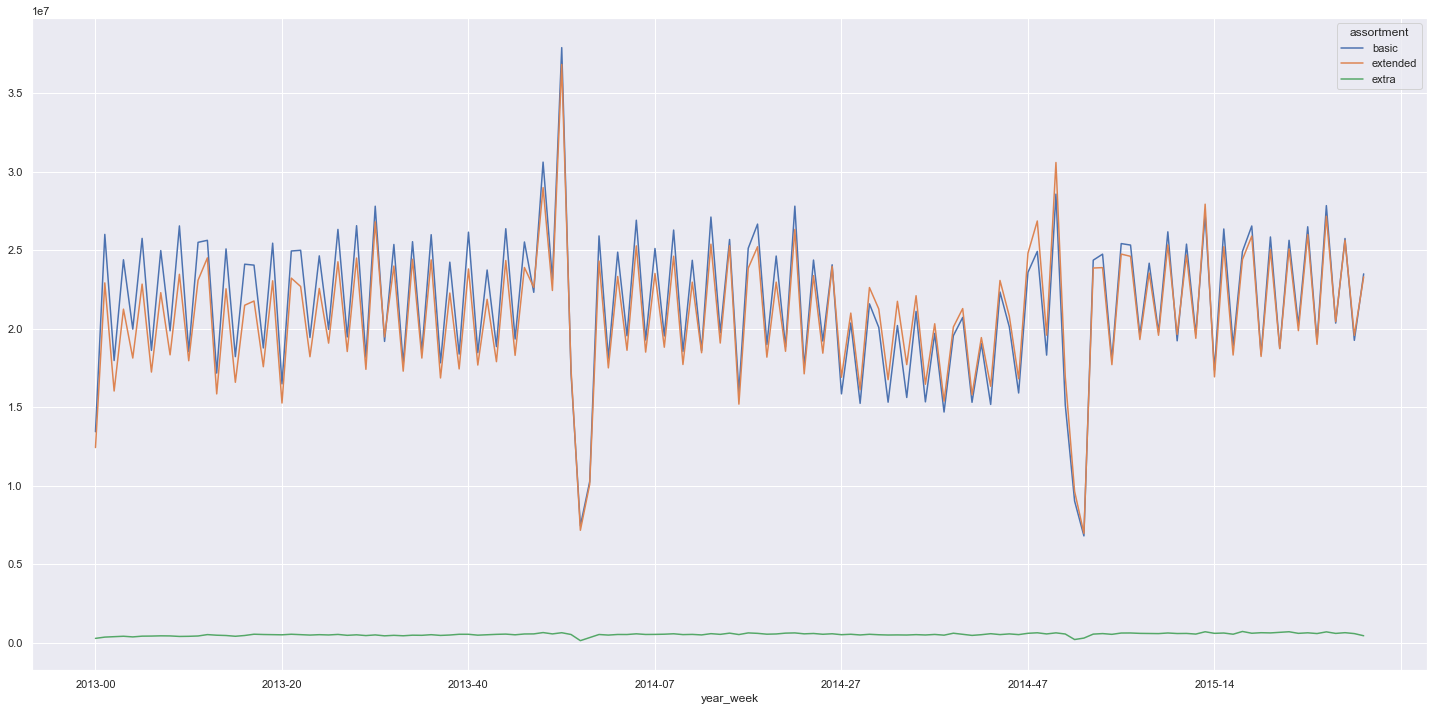

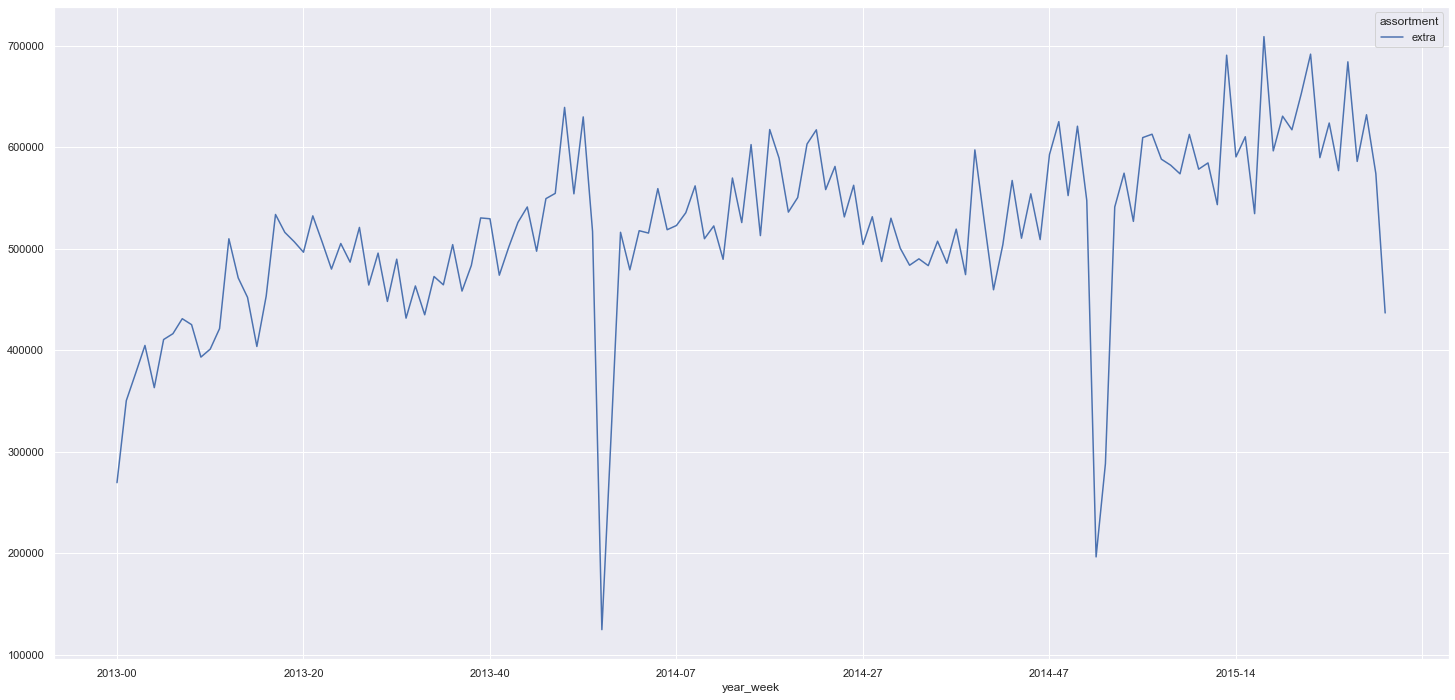

In [32]:
# Plota um gráfico com o comportamento temporal dos diferentes tipos de assortment ao longo das semanas
aux1 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux1.pivot(index='year_week', columns='assortment', values='sales').plot()

# Plota um gráfico com o comportamento temporal apenas do assortment do tipo 'extra' ao longo das semanas
aux2 = aux1[aux1['assortment'] == 'extra']
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

### HF1. Há mais vendas nos feriados estaduais
**FALSO:** Nos feriados estaduais, a quantidade de vendas é MENOR.

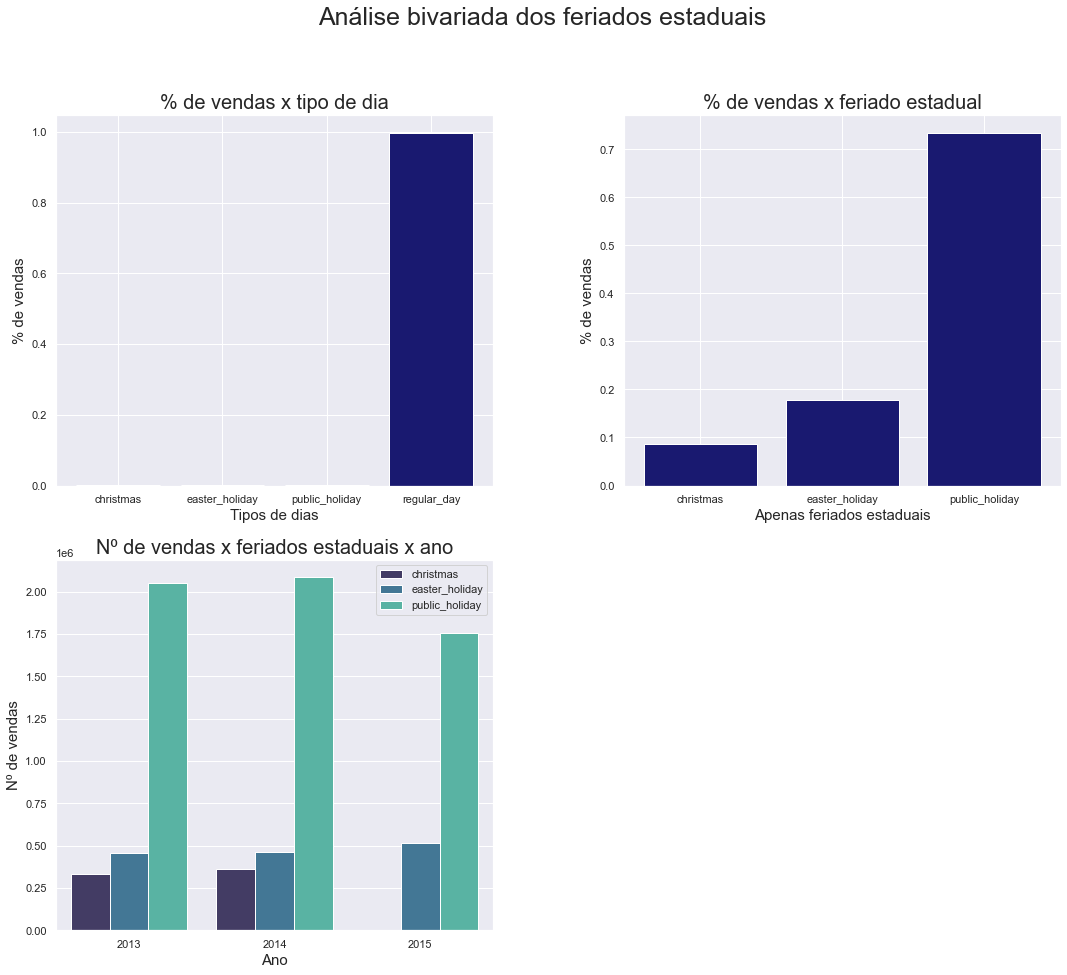

In [33]:
# Cria o gráfico
fig = plt.figure(figsize=(18, 15))

# Configura o título
fig.suptitle('Análise bivariada dos feriados estaduais', fontsize=25)
cor = 'midnightblue'

# Adiciona o primeiro subplot
aux1 = df4.loc[:, ['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
aux1['prop'] = aux1['sales'] / aux1['sales'].sum()
ax1 = fig.add_subplot(2, 2, 1)
ax1.bar(aux1['state_holiday'], aux1['prop'], color=cor)
ax1.set_title('% de vendas x tipo de dia', fontsize=20)
ax1.set_xlabel('Tipos de dias', fontsize=15)
ax1.set_ylabel('% de vendas', fontsize=15)

# Adiciona o segundo subplot
aux2 = df4.loc[df4['state_holiday'] != 'regular_day', ['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
aux2['prop'] = aux2['sales'] / aux2['sales'].sum()
ax2 = fig.add_subplot(2, 2, 2)
ax2.bar(aux2['state_holiday'], aux2['prop'], color=cor)
ax2.set_title('% de vendas x feriado estadual', fontsize=20)
ax2.set_xlabel('Apenas feriados estaduais', fontsize=15)
ax2.set_ylabel('% de vendas', fontsize=15)

# Adiciona o terceiro subplot
aux3 = df4.loc[df4['state_holiday'] != 'regular_day', ['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
ax3 = fig.add_subplot(2, 2, 3)
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux3, ax=ax3, palette='mako')
ax3.legend(loc='upper right')
ax3.set_title('Nº de vendas x feriados estaduais x ano', fontsize=20)
ax3.set_xlabel('Ano', fontsize=15)
ax3.set_ylabel('Nº de vendas', fontsize=15)

# Ajusta o espaço entre os subplots
fig.subplots_adjust(wspace=0.3)

# Plota e mostra o gráfico
plt.show()

### HF2. Há mais vendas nos feriados escolares
**FALSO:** Nos feriados escolares, a quantidade de vendas é MENOR.

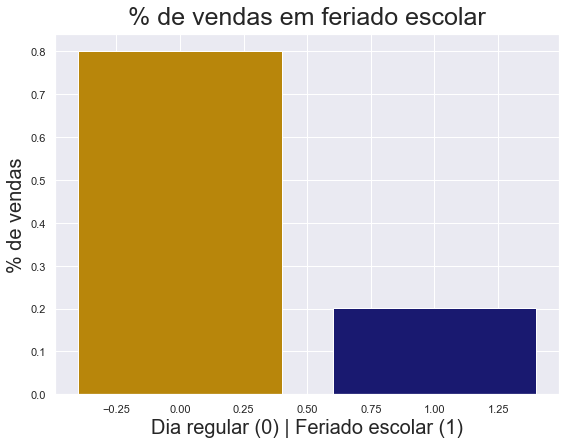

In [34]:
# Filtra e agrupa
df_aux = df4.loc[:, ['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
df_aux['prop'] = df_aux['sales'] / df_aux['sales'].sum()

# Cria o gráfico
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])

# Define a lista de cores e destaca a maior
max_idx = df_aux['sales'].argmax()
colors = ['midnightblue'] * len(df_aux)
colors[max_idx] = 'darkgoldenrod'

# Configura o título e os eixos
ax.set_title('% de vendas em feriado escolar', fontsize=25, pad=10)
ax.set_xlabel('Dia regular (0) | Feriado escolar (1)', fontsize=20)
ax.set_ylabel('% de vendas', fontsize=20)

# Plota e mostra o gráfico
ax.bar(df_aux['school_holiday'], df_aux['prop'], color=colors)
plt.show()

### HP1. Em dias de promoções tradicionais, as vendas aumentam
**VERDADE:** Em dias de promoções 

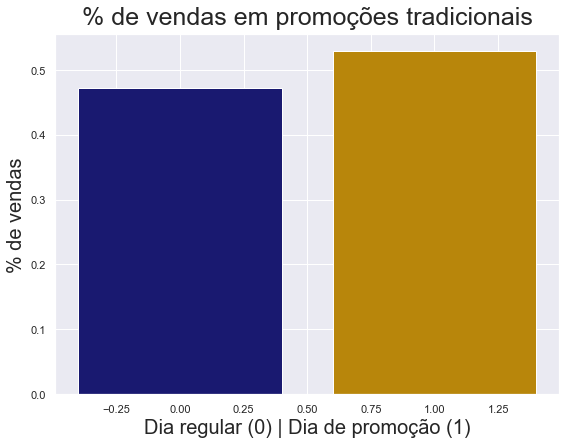

In [35]:
# Faz a soma de vendas
df_aux = df4.loc[:, ['promo', 'sales']].groupby('promo').sum().reset_index()
df_aux['prop'] = df_aux['sales'] / df_aux['sales'].sum()

# Cria o gráfico
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])

# Define a lista de cores e destaca a maior
max_idx = df_aux['sales'].argmax()
colors = ['midnightblue'] * len(df_aux)
colors[max_idx] = 'darkgoldenrod'

# Configura o título e os eixos
ax.set_title('% de vendas em promoções tradicionais', fontsize=25, pad=10)
ax.set_xlabel('Dia regular (0) | Dia de promoção (1)', fontsize=20)
ax.set_ylabel('% de vendas', fontsize=20)

# Plota e mostra o gráfico
ax.bar(df_aux['promo'], df_aux['prop'], color=colors)
plt.show()

### HP2. Quanto mais promoções contínuas, mais vendas
**FALSO:**

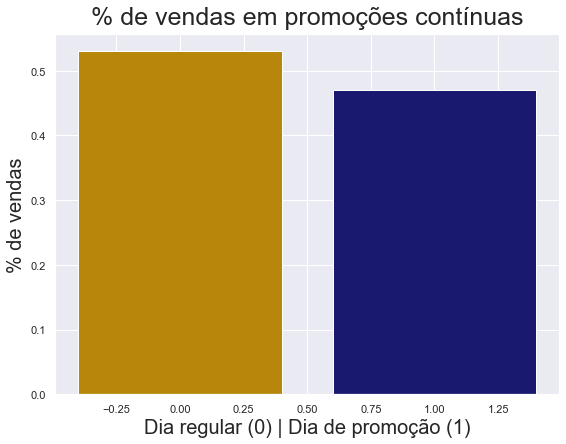

In [36]:
# Faz a soma de vendas
df_aux = df4.loc[:, ['promo2', 'sales']].groupby('promo2').sum().reset_index()
df_aux['prop'] = df_aux['sales'] / df_aux['sales'].sum()

# Cria o gráfico
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])

# Define a lista de cores e destaca a maior
max_idx = df_aux['sales'].argmax()
colors = ['midnightblue'] * len(df_aux)
colors[max_idx] = 'darkgoldenrod'

# Configura o título e os eixos
ax.set_title('% de vendas em promoções contínuas', fontsize=25, pad=10)
ax.set_xlabel('Dia regular (0) | Dia de promoção (1)', fontsize=20)
ax.set_ylabel('% de vendas', fontsize=20)

# Plota e mostra o gráfico
ax.bar(df_aux['promo2'], df_aux['prop'], color=colors)
plt.show()

### **HP3.** Quanto mais tempo de promoção, mais vendas
**FALSO:** Lojas com MAIS promoções consecutivas vendem MENOS.

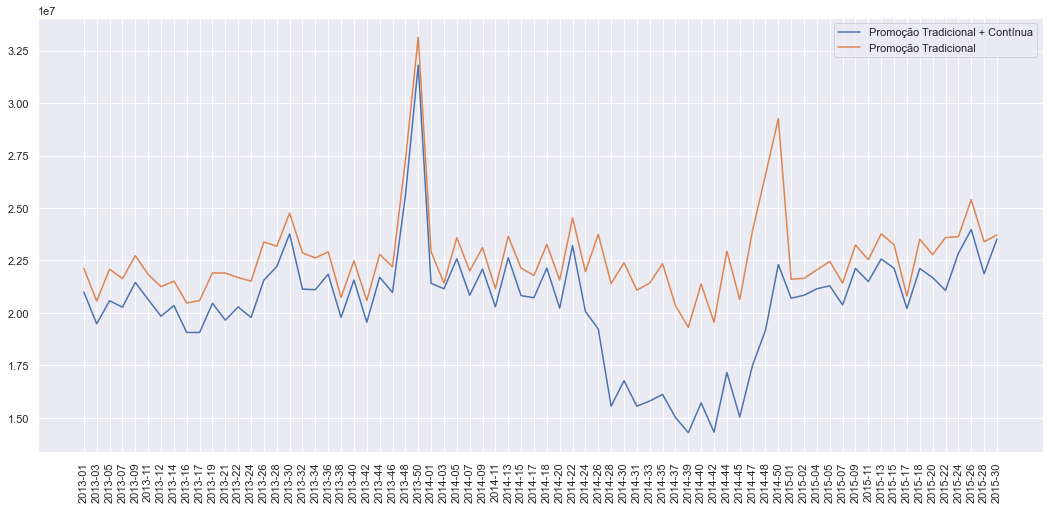

In [37]:
fig, ax = plt.subplots(figsize=(18, 8))

aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax.plot(aux1['year_week'], aux1['sales'])

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax.plot(aux2['year_week'], aux2['sales'])

ax.legend(labels=['Promoção Tradicional + Contínua', 'Promoção Tradicional'])

# Configura a rotação dos labels do eixo x para 90 graus
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show()

### <s>**HP4.** Quanto menor o intervalo entre as promoções, mais vendas</s>
**OBS.:** Será tratado no próximo ciclo CRISP.

### HC1. Quanto maior a distância da concorrência, mais vendas
**FALSO:** Quanto MAIOR a distância da concorrência, MENOR as vendas.

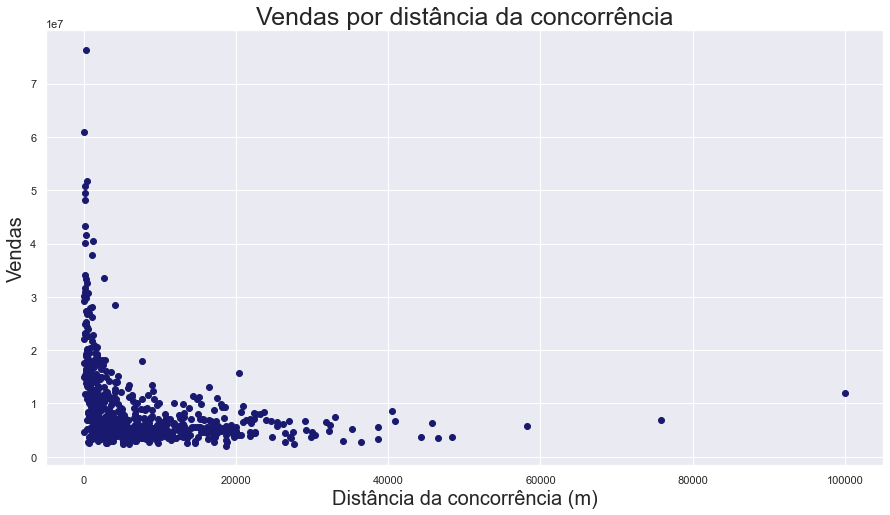

In [38]:
# Faz a soma de vendas por distância da concorrência
aux = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

# Cria e plota o gráfico
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.scatter(x='competition_distance',  y='sales', data=aux, color='midnightblue')

# Define o título e as labels dos eixos
ax.set_title('Vendas por distância da concorrência', fontsize=25)
ax.set_xlabel('Distância da concorrência (m)', fontsize=20)
ax.set_ylabel('Vendas', fontsize=20)

# Mostra o gráfico
plt.show()

### <s>**HC2.** Após abertura de concorr^6encia, as vendas diminuem</s>
**OBS.:** Será tratado no próximo ciclo CRISP.

## 4.3. Análise Multivariada
- Como as variáveis estão correlacionadas?
- Qual a força de correlação entre elas?
- Identificar e remover colunas que carregam o mesmo conteúdo de informação.

👉 É sempre bom lembrar que correlação não implica causalidade, só pq as variáveis estão correlacionadas não necessariamente uma causa a outra.

### 4.3.1. Numerical Attributes

In [39]:
num_attributes.columns

Index(['store', 'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'day_of_week', 'sales', 'promo', 'school_holiday',
       'year', 'month'],
      dtype='object')

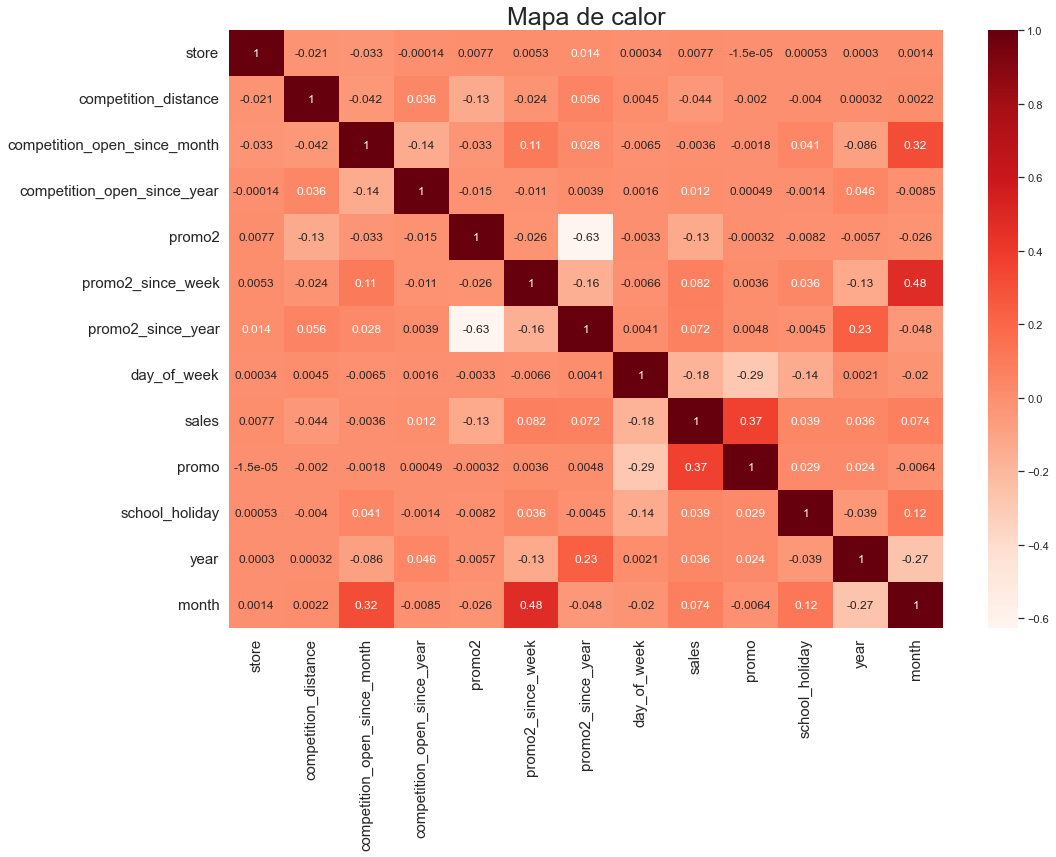

In [40]:
# Na correlação entre as variáveis, aquelas que mais afetam a quantidade de vendas são: 
# --> diretamente proporcionais: promo (37%)
# --> inversamente proporcionais: day_of_week ( -18% ) e promo2 (-13% )

# Criar o mapa de calor
corr = df4.corr(method='pearson')
fig, ax = plt.subplots(figsize=(16, 11))

# Configura o título e os eixos
ax.set_title('Mapa de calor', fontsize=25)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)

# Plota e mostra o gráfico
ax = sns.heatmap(corr, annot=True, cmap='Reds', ax=ax)
plt.show()

# SUGESTÕES: 
# --> Encodar os dias da semana com o mesmo peso (utilizando dummies), para entender melhor essa correlação.

### 4.3.2. Categorical Attributes

In [41]:
cat_attributes.columns

Index(['store_type', 'assortment', 'promo_interval', 'state_holiday',
       'year_week'],
      dtype='object')

#### 4.3.2.1. Encodar utilizando dummies

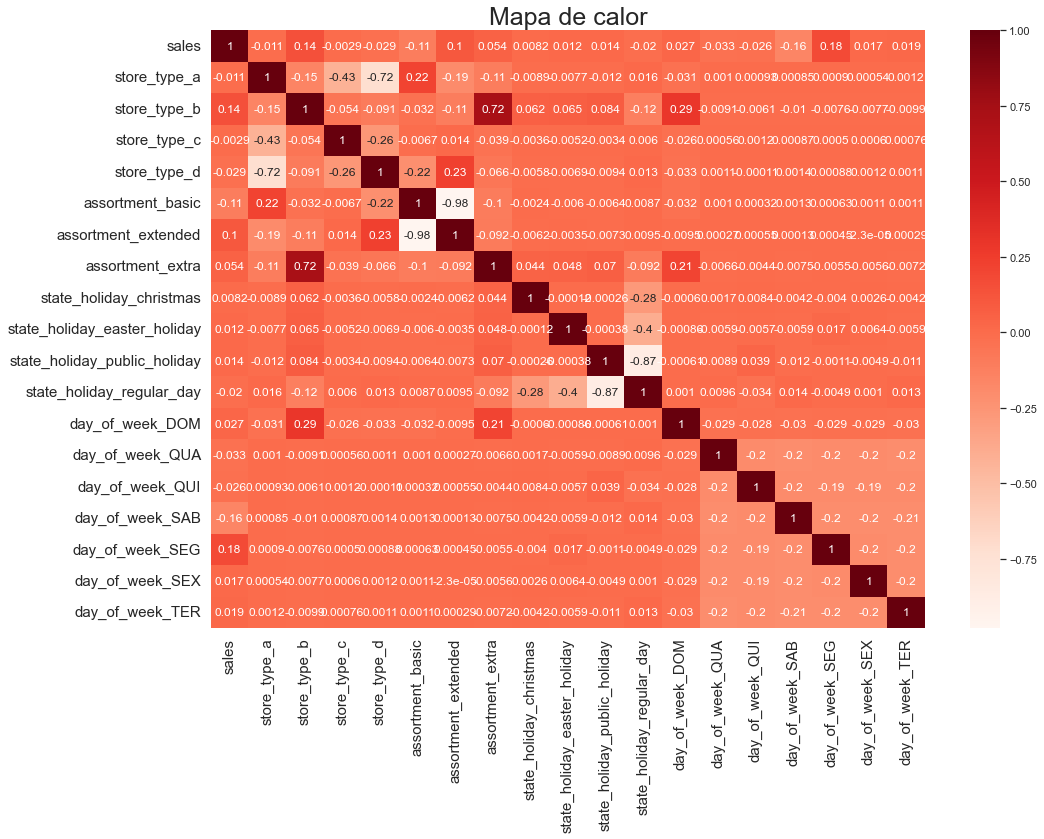

In [44]:
# Selecionar variáveis categóricas e incluir a coluna 'sales'
df_cat = cat_attributes.copy()
df_cat['sales'] = df4['sales']

# Transformar 'day_of_week' em variável categórica
day_of_week_rename = {1:'SEG', 2:'TER', 3:'QUA', 4:'QUI', 5:'SEX', 6:'SAB', 7:'DOM'}
df_cat['day_of_week'] = df4['day_of_week'].map(day_of_week_rename)

# ENCODAR VARIÁVEIS CATEGÓRICAS
# --> Vamos utilizar o OneHotEncoder 'store_types'
df_cat = dummies(df_cat, 'store_type')

# --> Vamos utilizar o OneHotEncoder 'assortment'
df_cat = dummies(df_cat, 'assortment')

# --> Vamos utilizar o OneHotEncoder 'state_holiday'
df_cat = dummies(df_cat, 'state_holiday')

# --> Vamos utilizar o OneHotEncoder 'day_of_week'
df_cat = dummies(df_cat, 'day_of_week')

# Na correlação entre as variáveis, aquelas que mais afetam a quantidade de vendas são: 
# --> diretamente proporcionais: day_of_week_SEG (18%), store_type_b ( 14% ) e assortment_extended( 10% )
# --> inversamente proporcionais: day_of_week_SAB (-16%) e assortment_basic( -11% )
# --> NOTA-SE QUE: há uma grande correlação entre: store_type_a e assortment_basic
#                                                  store_type_b e assortment_extra
#                                                  store_type_d e assortment_extended

# Criar o mapa de calor
corr = df_cat.corr(method='pearson')
fig, ax = plt.subplots(figsize=(16, 11))

# Configura o título e os eixos
ax.set_title('Mapa de calor', fontsize=25)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)

# Plota e mostra o gráfico
ax = sns.heatmap(corr, annot=True, cmap='Reds', ax=ax)
plt.show()

#### 4.3.2.2. V de Cramer

<Axes: >

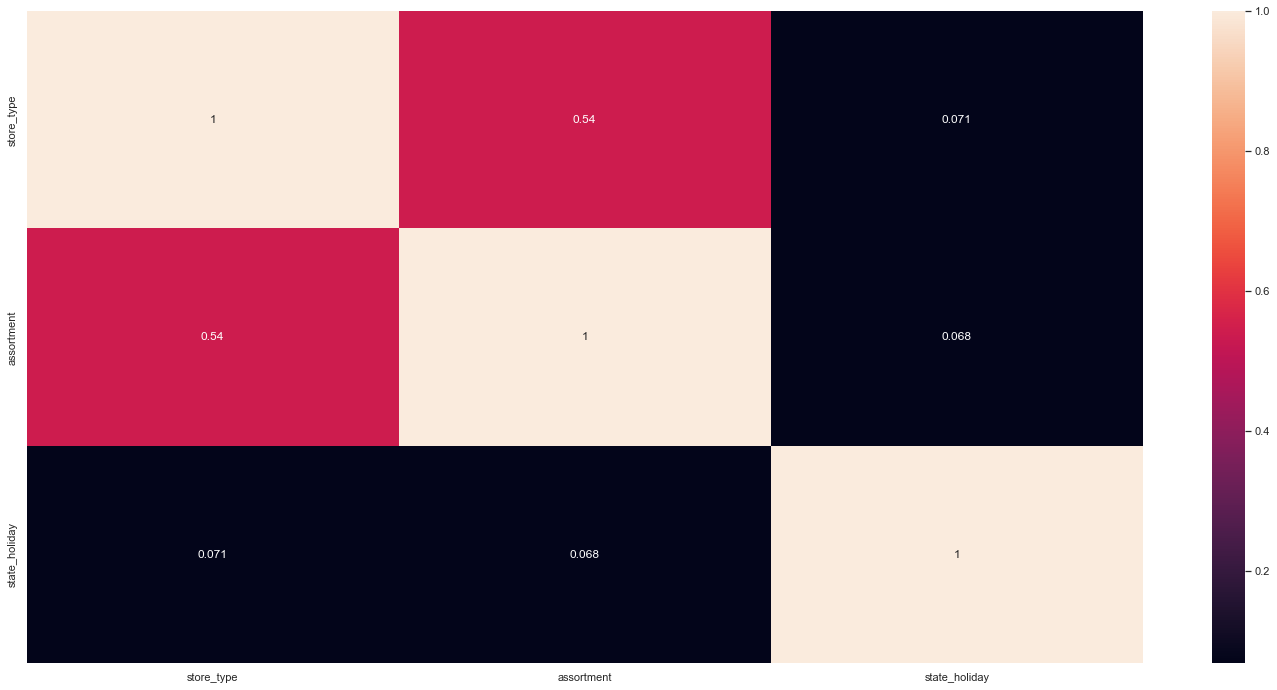

In [56]:
# Análise de correlação entre as variáveis
# --> Comprova que existe uma correlação forte entre 'assortment' e 'store_type'

# Apenas variáveis categóricos
a = cat_attributes.copy()

# Calcular V de Cramer
a1 = cramer_v(a['store_type'], a['store_type'])
a2 = cramer_v(a['store_type'], a['assortment'])
a3 = cramer_v(a['store_type'], a['state_holiday'])

a4 = cramer_v(a['assortment'], a['store_type'])
a5 = cramer_v(a['assortment'], a['assortment'])
a6 = cramer_v(a['assortment'], a['state_holiday'])

a7 = cramer_v(a['state_holiday'], a['store_type'])
a8 = cramer_v(a['state_holiday'], a['assortment'])
a9 = cramer_v(a['state_holiday'], a['state_holiday'])

#Final dataset
d = pd.DataFrame({'store_type': [a1, a2, a3],
                  'assortment': [a4, a5, a6],
                  'state_holiday': [a7, a8, a9]})
d = d.set_index(d.columns)

# Mostra o gráfico
sns.heatmap (d, annot=True)

# 5. PASSO 05  - DATA PREPARATION

In [57]:
df5 = df4.copy()

In [51]:
df5

,store,store_type,assortment,competition_distance,promo2,day_of_week,date,sales,customers,promo,state_holiday,school_holiday,year_week
0,1,c,basic,1270.0,0,5,2015-07-31,5263,555,1,regular_day,1,2015-30
1,1,c,basic,1270.0,0,4,2015-07-30,5020,546,1,regular_day,1,2015-30
2,1,c,basic,1270.0,0,3,2015-07-29,4782,523,1,regular_day,1,2015-30
3,1,c,basic,1270.0,0,2,2015-07-28,5011,560,1,regular_day,1,2015-30
4,1,c,basic,1270.0,0,1,2015-07-27,6102,612,1,regular_day,1,2015-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
844333,1115,d,extended,5350.0,1,1,2013-01-07,6905,471,1,regular_day,1,2013-01
844334,1115,d,extended,5350.0,1,6,2013-01-05,4771,339,0,regular_day,1,2013-00
844335,1115,d,extended,5350.0,1,5,2013-01-04,4540,326,0,regular_day,1,2013-00
844336,1115,d,extended,5350.0,1,4,2013-01-03,4297,300,0,regular_day,1,2013-00


# 6. PASSO 06 - FEATURE SELECTION

In [ ]:
df6 = df5.copy()

# 7. PASSO 07  - MACHINE LEARNING MODELING

# 8. PASSO 08  - HYPERPARAMETER FINE TUNING

# 9. PASSO 09 - ERROR TRANSLATION AND INTERPRETATION